# Implementing a Low Rank Adapter (LoRA) (8 points)

Objective of this exercice:

Given a neural network (NN) classifier pre-trained on the subset of MNIST containing digits 0...4,
you will fine-tune this NN, by optimizing all weights, and compare the test accuracy of this baseline model versus fine-tuning a LoRA.

The neural network that we will define is artificially big because LoRA is usually applied to Large Language Models of billions of parameters

**What is a LoRA ?**

LoRA (Low-Rank Adaptation of Large Language Models) is a popular and lightweight training technique that significantly reduces the number of trainable parameters. It works by inserting a smaller number of new weights into the model and only these are trained. This makes training with LoRA much faster, memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share.

<div style="display: flex; justify-content: space-between;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_fig.png' style="width: 30%;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_text.png' style="width: 70%;">
</div>



References:

https://arxiv.org/pdf/2106.09685.pdf

https://lightning.ai/pages/community/tutorial/lora-llm/

https://huggingface.co/docs/diffusers/main/en/training/lora


In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn.utils.parametrize as parametrize
import torchvision.transforms as transforms
import math

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Make torch deterministic
_ = torch.manual_seed(0)


# Decide which device we want to run on
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [2]:
#Normalizing MNIST
#These values are the mean and std deviation of the MNIST dataset.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# load MNIST
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# keep images of desired labels
class_names = [0, 1, 2, 3, 4]

# create a mask to filter indices for each label
train_mask = torch.tensor([label in class_names for label in mnist_train.targets])
test_mask = torch.tensor([label in class_names for label in mnist_test.targets])

# Create Subset datasets for train, validation, and test
train_dataset = Subset(mnist_train, torch.where(train_mask)[0])
test_dataset = Subset(mnist_test, torch.where(test_mask)[0])

# split train into train & validation
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size=128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 66403524.07it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 77651085.78it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29858525.51it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3786628.66it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
len(train_dataset),len(val_dataset),len(test_dataset)

(21417, 9179, 5139)

# Architecture of the classifier

In [4]:
#note that last layer has 5 neurons for digits 0...4
#and the same layer will be used for 5...9

class classifier(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000):
        super(classifier,self).__init__()

        self.linear1 = nn.Linear(28*28, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, 5)
        self.relu = nn.ReLU()


        self.dropout = nn.Dropout(0.5)



    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        return x

net = classifier().to(device)

# Code for training loop & validation

In [5]:
#We set a lower learning rate when we will fine-tune on the subset of MNIST containing digits 5...9
#so that fine-tuning don't change pre-training weights too much.

#Since the NN is big, we add weight decay to regularize it otherwise it will overfit too much too fast
def adjust_optimizer(name, parameters):
    lr = 0.001
    if name == "subset2":
        lr = 0.00001
    return torch.optim.Adam(parameters, lr=lr, weight_decay=0.0001)

#to do label prediction during training we use argmax on the last layer, which output a vector of 5 components
#so y_hat will be between 0 and 4, we thus have to "translate" y_true so that it's in the right range

# the name variable will be used later on to recognize on which dataset we are
# and do the corresponding label translation, and set the good hyperparameters
def process_labels(name, labels):
    if 'subset2' in name:
        labels = labels - 5
    return labels


def run_epoch(loader, name, net, optimizer, cross_el, total_iterations_limit=None):
    net.train() if optimizer else net.eval()

    loss_sum = 0
    num_iterations = 0

    data_iterator = tqdm(loader, desc=f'Training' if optimizer else f'Validation')
    if total_iterations_limit is not None:
        data_iterator.total = total_iterations_limit

    for data in data_iterator:
        num_iterations += 1
        x, y = data
        x, y = x.to(device), y.to(device)
        x = x.view(-1, 28*28)
        optimizer.zero_grad() if optimizer else None
        output = net(x)
        loss = cross_el(output, process_labels(name, y))
        loss_sum += loss.item()
        avg_loss = loss_sum / num_iterations
        data_iterator.set_postfix(loss=avg_loss)
        if optimizer:
            loss.backward()
            optimizer.step()

    return loss_sum / len(data_iterator)

def train(train_loader, val_loader, name, net, epochs=5, total_iterations_limit=None):
    cross_el = nn.CrossEntropyLoss()
    optimizer = adjust_optimizer(name, net.parameters())

    total_iterations = 0
    train_loss_lst, val_loss_lst = [], []

    for epoch in range(epochs):
        train_loss = run_epoch(train_loader, name, net, optimizer, cross_el, total_iterations_limit)
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss}")
        train_loss_lst.append(train_loss)

        val_loss = run_epoch(val_loader, name, net, None, cross_el, total_iterations_limit)
        print(f"Epoch [{epoch+1}/{epochs}] Validation Loss: {val_loss}")
        val_loss_lst.append(val_loss)

    return train_loss_lst, val_loss_lst

In [6]:
def plot_losses(train_loss_lst, val_loss_lst):
    plt.plot(train_loss_lst,label="train")
    plt.plot(val_loss_lst,label="val")
    plt.legend()

# If you have GPU access, or simply want to train your own model, run this code

In [7]:
train_loss_lst, val_loss_lst = train(train_loader, val_loader, "subset1", net, epochs=30)

Training: 100%|██████████| 168/168 [00:21<00:00,  7.80it/s, loss=0.15]


Epoch [1/30] Train Loss: 0.1496486769423687


Validation: 100%|██████████| 72/72 [00:04<00:00, 17.21it/s, loss=0.0717]


Epoch [1/30] Validation Loss: 0.0717043834609083


Training: 100%|██████████| 168/168 [00:20<00:00,  8.17it/s, loss=0.0718]


Epoch [2/30] Train Loss: 0.0718296590050505


Validation: 100%|██████████| 72/72 [00:04<00:00, 17.94it/s, loss=0.0501]


Epoch [2/30] Validation Loss: 0.05010759814952811


Training: 100%|██████████| 168/168 [00:20<00:00,  8.03it/s, loss=0.0566]


Epoch [3/30] Train Loss: 0.05661011381085873


Validation: 100%|██████████| 72/72 [00:03<00:00, 18.52it/s, loss=0.0446]


Epoch [3/30] Validation Loss: 0.04460756934228508


Training: 100%|██████████| 168/168 [00:22<00:00,  7.50it/s, loss=0.0499]


Epoch [4/30] Train Loss: 0.04991993713026334


Validation: 100%|██████████| 72/72 [00:04<00:00, 17.42it/s, loss=0.0529]


Epoch [4/30] Validation Loss: 0.05291139711334836


Training: 100%|██████████| 168/168 [00:20<00:00,  8.00it/s, loss=0.0465]


Epoch [5/30] Train Loss: 0.04646402267237482


Validation: 100%|██████████| 72/72 [00:03<00:00, 18.35it/s, loss=0.0393]


Epoch [5/30] Validation Loss: 0.03932266803005607


Training: 100%|██████████| 168/168 [00:21<00:00,  7.96it/s, loss=0.038]


Epoch [6/30] Train Loss: 0.03800202621745744


Validation: 100%|██████████| 72/72 [00:03<00:00, 18.42it/s, loss=0.0427]


Epoch [6/30] Validation Loss: 0.042682658751598664


Training: 100%|██████████| 168/168 [00:23<00:00,  7.16it/s, loss=0.036]


Epoch [7/30] Train Loss: 0.03599903619604967


Validation: 100%|██████████| 72/72 [00:04<00:00, 15.67it/s, loss=0.0404]


Epoch [7/30] Validation Loss: 0.040441032727459164


Training: 100%|██████████| 168/168 [00:34<00:00,  4.83it/s, loss=0.0391]


Epoch [8/30] Train Loss: 0.03911041584866498


Validation: 100%|██████████| 72/72 [00:04<00:00, 14.95it/s, loss=0.0454]


Epoch [8/30] Validation Loss: 0.045403564528290495


Training: 100%|██████████| 168/168 [00:22<00:00,  7.61it/s, loss=0.0307]


Epoch [9/30] Train Loss: 0.03068079742349385


Validation: 100%|██████████| 72/72 [00:05<00:00, 14.13it/s, loss=0.0437]


Epoch [9/30] Validation Loss: 0.04367495745747066


Training: 100%|██████████| 168/168 [00:22<00:00,  7.43it/s, loss=0.034]


Epoch [10/30] Train Loss: 0.03404740250455992


Validation: 100%|██████████| 72/72 [00:04<00:00, 15.04it/s, loss=0.0437]


Epoch [10/30] Validation Loss: 0.043729274988032155


Training: 100%|██████████| 168/168 [00:22<00:00,  7.49it/s, loss=0.0316]


Epoch [11/30] Train Loss: 0.03158334609802945


Validation: 100%|██████████| 72/72 [00:04<00:00, 17.41it/s, loss=0.0438]


Epoch [11/30] Validation Loss: 0.04383580772991991


Training: 100%|██████████| 168/168 [00:22<00:00,  7.53it/s, loss=0.0304]


Epoch [12/30] Train Loss: 0.030354504253149832


Validation: 100%|██████████| 72/72 [00:04<00:00, 17.97it/s, loss=0.0399]


Epoch [12/30] Validation Loss: 0.03992549713600763


Training: 100%|██████████| 168/168 [00:22<00:00,  7.41it/s, loss=0.0323]


Epoch [13/30] Train Loss: 0.032325054520957304


Validation: 100%|██████████| 72/72 [00:04<00:00, 17.82it/s, loss=0.0519]


Epoch [13/30] Validation Loss: 0.05187462159058972


Training: 100%|██████████| 168/168 [00:22<00:00,  7.63it/s, loss=0.0268]


Epoch [14/30] Train Loss: 0.026842682963130454


Validation: 100%|██████████| 72/72 [00:04<00:00, 17.69it/s, loss=0.0481]


Epoch [14/30] Validation Loss: 0.048125276581534614


Training: 100%|██████████| 168/168 [00:21<00:00,  7.74it/s, loss=0.031]


Epoch [15/30] Train Loss: 0.030952567771670318


Validation: 100%|██████████| 72/72 [00:04<00:00, 17.92it/s, loss=0.0405]


Epoch [15/30] Validation Loss: 0.04046014484609057


Training: 100%|██████████| 168/168 [00:21<00:00,  7.72it/s, loss=0.0219]


Epoch [16/30] Train Loss: 0.02189853448518469


Validation: 100%|██████████| 72/72 [00:03<00:00, 18.57it/s, loss=0.0379]


Epoch [16/30] Validation Loss: 0.03791717265812622


Training: 100%|██████████| 168/168 [00:21<00:00,  7.74it/s, loss=0.0245]


Epoch [17/30] Train Loss: 0.024507689973731994


Validation: 100%|██████████| 72/72 [00:03<00:00, 18.30it/s, loss=0.0536]


Epoch [17/30] Validation Loss: 0.053638019761415814


Training: 100%|██████████| 168/168 [00:22<00:00,  7.63it/s, loss=0.0304]


Epoch [18/30] Train Loss: 0.03036639379622232


Validation: 100%|██████████| 72/72 [00:04<00:00, 17.94it/s, loss=0.0568]


Epoch [18/30] Validation Loss: 0.0568442587690596


Training: 100%|██████████| 168/168 [00:22<00:00,  7.56it/s, loss=0.0333]


Epoch [19/30] Train Loss: 0.033277845430261334


Validation: 100%|██████████| 72/72 [00:03<00:00, 18.02it/s, loss=0.048]


Epoch [19/30] Validation Loss: 0.048035392998473175


Training: 100%|██████████| 168/168 [00:21<00:00,  7.67it/s, loss=0.0254]


Epoch [20/30] Train Loss: 0.025439101820536183


Validation: 100%|██████████| 72/72 [00:03<00:00, 18.33it/s, loss=0.0494]


Epoch [20/30] Validation Loss: 0.0494149261923869


Training: 100%|██████████| 168/168 [00:22<00:00,  7.49it/s, loss=0.0202]


Epoch [21/30] Train Loss: 0.020187362727786724


Validation: 100%|██████████| 72/72 [00:04<00:00, 17.09it/s, loss=0.0416]


Epoch [21/30] Validation Loss: 0.041640819526037376


Training: 100%|██████████| 168/168 [00:22<00:00,  7.48it/s, loss=0.0217]


Epoch [22/30] Train Loss: 0.021733867200488192


Validation: 100%|██████████| 72/72 [00:04<00:00, 15.20it/s, loss=0.0449]


Epoch [22/30] Validation Loss: 0.04494298558663306


Training: 100%|██████████| 168/168 [00:21<00:00,  7.68it/s, loss=0.0313]


Epoch [23/30] Train Loss: 0.03130934917732832


Validation: 100%|██████████| 72/72 [00:04<00:00, 14.78it/s, loss=0.037]


Epoch [23/30] Validation Loss: 0.03696583952210454


Training: 100%|██████████| 168/168 [00:21<00:00,  7.67it/s, loss=0.0206]


Epoch [24/30] Train Loss: 0.02056044591188852


Validation: 100%|██████████| 72/72 [00:04<00:00, 15.33it/s, loss=0.0436]


Epoch [24/30] Validation Loss: 0.04359011024903086


Training: 100%|██████████| 168/168 [00:22<00:00,  7.37it/s, loss=0.0228]


Epoch [25/30] Train Loss: 0.022801924207929654


Validation: 100%|██████████| 72/72 [00:04<00:00, 17.43it/s, loss=0.0438]


Epoch [25/30] Validation Loss: 0.04379920160651333


Training: 100%|██████████| 168/168 [00:22<00:00,  7.39it/s, loss=0.0243]


Epoch [26/30] Train Loss: 0.024333403339802488


Validation: 100%|██████████| 72/72 [00:03<00:00, 18.33it/s, loss=0.0489]


Epoch [26/30] Validation Loss: 0.048850033541990946


Training: 100%|██████████| 168/168 [00:23<00:00,  7.22it/s, loss=0.0216]


Epoch [27/30] Train Loss: 0.021584677122172297


Validation: 100%|██████████| 72/72 [00:04<00:00, 17.91it/s, loss=0.0411]


Epoch [27/30] Validation Loss: 0.041125498061369906


Training: 100%|██████████| 168/168 [00:22<00:00,  7.35it/s, loss=0.0191]


Epoch [28/30] Train Loss: 0.01906033294467523


Validation: 100%|██████████| 72/72 [00:04<00:00, 17.77it/s, loss=0.0442]


Epoch [28/30] Validation Loss: 0.04424800988126915


Training: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s, loss=0.0223]


Epoch [29/30] Train Loss: 0.02225607313405254


Validation: 100%|██████████| 72/72 [00:04<00:00, 17.92it/s, loss=0.048]


Epoch [29/30] Validation Loss: 0.04796971992004728


Training: 100%|██████████| 168/168 [00:22<00:00,  7.37it/s, loss=0.0245]


Epoch [30/30] Train Loss: 0.024538102384256143


Validation: 100%|██████████| 72/72 [00:04<00:00, 16.31it/s, loss=0.0507]

Epoch [30/30] Validation Loss: 0.050743958475158654


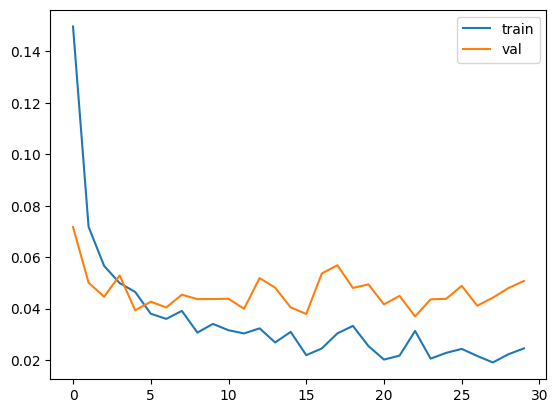

In [8]:
plot_losses(train_loss_lst,val_loss_lst)

In [9]:
# save the model
path1= "./models/model.pth"
torch.save(net,path1)

path2= "./models/model_state_dict.pth"
# Save the state dictionary
torch.save(net.state_dict(), path2)

# Otherwise load an already pre-trained model
Either the one you have created above, either the one already available at https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/models/


In [10]:
net=torch.load(path1).to(device)

# Count the number of weights & compare it with parameters added by LoRA

In [11]:
original_weights = {}
for name, param in net.named_parameters():
    original_weights[name] = param.clone().detach()

In [12]:
# Print the size of the weights matrices of the network
# Save the count of the total number of parameters
net.eval()
total_parameters_original = 0
for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')


Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([5, 2000]) + B: torch.Size([5])
Total number of parameters: 2,797,005


# Test the model on digits 0...4

In [13]:
def test(loader, name, net, wrong_counts):
    correct = 0
    total = 0

    net.eval()
    with torch.no_grad():
        for data in tqdm(loader, desc=name):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            y = process_labels(name, y)
            output = net(x.view(-1, 784))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                else:
                    wrong_digit = y[idx].item() + 5 if 'subset2' in name else y[idx].item()
                    wrong_counts[wrong_digit] += 1

                total += 1

    accuracy = round(correct / total, 3)
    print(f'Accuracy: {accuracy}')
    for key, value in wrong_counts.items():
        print(f'Wrong counts for the digit {key}: {value}')

    return accuracy

test(test_loader, "Testing", net, {i: 0 for i in range(5)})


Testing: 100%|██████████| 41/41 [00:02<00:00, 18.51it/s]

Accuracy: 0.992
Wrong counts for the digit 0: 5
Wrong counts for the digit 1: 5
Wrong counts for the digit 2: 20
Wrong counts for the digit 3: 4
Wrong counts for the digit 4: 5


0.992

# Define train, validation, test sets for digits 5...9

__Question 1 (0.25 points) :__

In [14]:
#same code as before except for the mask

# create a mask to filter indices for each label, retrieve digits 5...9
class_names_subset2 = [5, 6, 7, 8, 9]
train_mask_subset2 = torch.tensor([label in class_names_subset2 for label in mnist_train.targets])
test_mask_subset2 = torch.tensor([label in class_names_subset2 for label in mnist_test.targets])

# Create Subset datasets for train, validation, and test
train_dataset_subset2 = Subset(mnist_train, torch.where(train_mask_subset2)[0])
test_dataset_subset2 = Subset(mnist_test, torch.where(test_mask_subset2)[0])

# split train into train & validation
train_size_subset2 = int(0.7 * len(train_dataset_subset2))
val_size_subset2 = len(train_dataset_subset2) - train_size_subset2
train_dataset_subset2, val_dataset_subset2 = random_split(train_dataset_subset2, [train_size_subset2, val_size_subset2])

train_loader_subset2 = DataLoader(train_dataset_subset2, batch_size=batch_size, shuffle=True)
val_loader_subset2 = DataLoader(val_dataset_subset2, batch_size=batch_size, shuffle=False)
test_loader_subset2 = DataLoader(test_dataset_subset2, batch_size=batch_size, shuffle=False)


# Verify that pre-trained model on digits 0...4 is bad on digits 5...9

__Question 2 (0.25 points) :__

You should display the number of wrong predictions for each digits & global accuracy. \
Note that it's better than random guess ($\frac{1}{5}\times 100= $20%) for digit 8 and 9 because 3 looks like 8 and 4 looks like 9


In [15]:
wrong_counts_subset2 = {i: 0 for i in range(5, 10)}
accuracy_subset2 = test(test_loader_subset2, "Testing subset2", net, wrong_counts_subset2)

Testing subset2: 100%|██████████| 38/38 [00:02<00:00, 18.64it/s]

Accuracy: 0.429
Wrong counts for the digit 5: 765
Wrong counts for the digit 6: 940
Wrong counts for the digit 7: 633
Wrong counts for the digit 8: 347
Wrong counts for the digit 9: 93


# Fine-tune the model on digits 5...9

__Question 3 (0.5 points) :__

You will fine-tune all the layers of the model (ie. all parameters of all fully-connected matrices) for 10 epochs

In [17]:
# Fine-tune the model on digits 5...9
train_loss_lst_subset2, val_loss_lst_subset2 = train(train_loader_subset2, val_loader_subset2, "subset2", net, epochs=10)

# Evaluate the fine-tuned model on the test set of digits 5...9
wrong_counts_subset2_finetuned = {i: 0 for i in range(5, 10)}
accuracy_subset2_finetuned = test(test_loader_subset2, "Testing subset2", net, wrong_counts_subset2_finetuned)

Training: 100%|██████████| 161/161 [00:26<00:00,  6.17it/s, loss=2.34]


Epoch [1/10] Train Loss: 2.338326060994071


Validation: 100%|██████████| 69/69 [00:03<00:00, 18.26it/s, loss=1.5]


Epoch [1/10] Validation Loss: 1.4986538627873296


Training: 100%|██████████| 161/161 [00:22<00:00,  7.23it/s, loss=1.59]


Epoch [2/10] Train Loss: 1.589279113719182


Validation: 100%|██████████| 69/69 [00:03<00:00, 18.67it/s, loss=1.01]


Epoch [2/10] Validation Loss: 1.0054470317951147


Training: 100%|██████████| 161/161 [00:22<00:00,  7.27it/s, loss=1.1]


Epoch [3/10] Train Loss: 1.1017112428357143


Validation: 100%|██████████| 69/69 [00:03<00:00, 17.83it/s, loss=0.699]


Epoch [3/10] Validation Loss: 0.6992500277533047


Training: 100%|██████████| 161/161 [00:22<00:00,  7.29it/s, loss=0.802]


Epoch [4/10] Train Loss: 0.8022552186287708


Validation: 100%|██████████| 69/69 [00:04<00:00, 17.13it/s, loss=0.532]


Epoch [4/10] Validation Loss: 0.5324861005596493


Training: 100%|██████████| 161/161 [00:22<00:00,  7.20it/s, loss=0.631]


Epoch [5/10] Train Loss: 0.6310404163339863


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.27it/s, loss=0.427]


Epoch [5/10] Validation Loss: 0.4269043915513633


Training: 100%|██████████| 161/161 [00:22<00:00,  7.02it/s, loss=0.518]


Epoch [6/10] Train Loss: 0.5180471393262377


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.63it/s, loss=0.354]


Epoch [6/10] Validation Loss: 0.35426327823728754


Training: 100%|██████████| 161/161 [00:24<00:00,  6.67it/s, loss=0.438]


Epoch [7/10] Train Loss: 0.4382112795336646


Validation: 100%|██████████| 69/69 [00:03<00:00, 18.19it/s, loss=0.302]


Epoch [7/10] Validation Loss: 0.3017084980788438


Training: 100%|██████████| 161/161 [00:24<00:00,  6.53it/s, loss=0.388]


Epoch [8/10] Train Loss: 0.3878914640742059


Validation: 100%|██████████| 69/69 [00:03<00:00, 18.34it/s, loss=0.262]


Epoch [8/10] Validation Loss: 0.261729937100756


Training: 100%|██████████| 161/161 [00:24<00:00,  6.63it/s, loss=0.337]


Epoch [9/10] Train Loss: 0.3373802655046771


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.59it/s, loss=0.233]


Epoch [9/10] Validation Loss: 0.23252528279587842


Training: 100%|██████████| 161/161 [00:23<00:00,  6.73it/s, loss=0.311]


Epoch [10/10] Train Loss: 0.3108172336165209


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.63it/s, loss=0.21]


Epoch [10/10] Validation Loss: 0.2102203858287438


Testing subset2: 100%|██████████| 38/38 [00:01<00:00, 19.04it/s]

Accuracy: 0.938
Wrong counts for the digit 5: 73
Wrong counts for the digit 6: 24
Wrong counts for the digit 7: 60
Wrong counts for the digit 8: 84
Wrong counts for the digit 9: 60


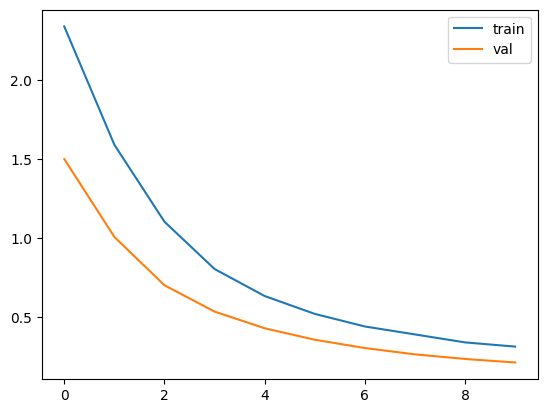

In [18]:
#plot the train and validation losses
plot_losses(train_loss_lst_subset2, val_loss_lst_subset2)

In [19]:
#test accuracy of fine-tuned model on digits 5...9
# & save this number into a variable, we will need it for final plot

# Test accuracy of fine-tuned model on digits 5...9
wrong_counts_subset2_finetuned = {i: 0 for i in range(5, 10)}
accuracy_subset2_finetuned = test(test_loader_subset2, "Testing subset2", net, wrong_counts_subset2_finetuned)

# Save the accuracy value into a variable for the final plot
accuracy_finetuned_all = accuracy_subset2_finetuned

Testing subset2: 100%|██████████| 38/38 [00:02<00:00, 18.99it/s]

Accuracy: 0.938
Wrong counts for the digit 5: 73
Wrong counts for the digit 6: 24
Wrong counts for the digit 7: 60
Wrong counts for the digit 8: 84
Wrong counts for the digit 9: 60


# Fine-tune the model on digits 5...9 with LoRA

__Question 4 (2.5 points) :__

You will now implement one LoRA per layer

In [64]:
class ModifiedClassifier(nn.Module):
    def __init__(self, lora_rank):
        super(ModifiedClassifier, self).__init__()
        # Load the pretrained model
        self.pretrained_net = classifier().to(device)
        self.pretrained_net.load_state_dict(torch.load(path2))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

        # Define lora hyperparameters
        self.lora_rank = lora_rank

        # Calculate the dimension "d" for each layer
        d1 = self.pretrained_net.linear1.in_features
        d2 = self.pretrained_net.linear2.in_features
        d3 = self.pretrained_net.linear3.in_features

        self.lora_alpha1 = lora_rank * d1
        self.lora_alpha2 = lora_rank * d2
        self.lora_alpha3 = lora_rank * d3

        self.lora_dropout = nn.Dropout(0.1)

        # Define lora weights matrices for each layer in pretrained model
        self.l1_lora_A = nn.Parameter(torch.zeros(self.lora_rank, d1))
        self.l1_lora_B = nn.Parameter(torch.zeros(self.pretrained_net.linear1.out_features, self.lora_rank))
        self.l2_lora_A = nn.Parameter(torch.zeros(self.lora_rank, d2))
        self.l2_lora_B = nn.Parameter(torch.zeros(self.pretrained_net.linear2.out_features, self.lora_rank))
        self.l3_lora_A = nn.Parameter(torch.zeros(self.lora_rank, d3))
        self.l3_lora_B = nn.Parameter(torch.zeros(self.pretrained_net.linear3.out_features, self.lora_rank))

        # Initialization for lora layers
        nn.init.kaiming_uniform_(self.l1_lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.l1_lora_B)
        nn.init.kaiming_uniform_(self.l2_lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.l2_lora_B)
        nn.init.kaiming_uniform_(self.l3_lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.l3_lora_B)

        # Freeze non-LoRA weights
        for param in self.pretrained_net.parameters():
            param.requires_grad = False

    def lora_linear(self, x, layer, lora_A, lora_B, lora_alpha):
        # Implement formula (3) in arxiv.org/pdf/2106.09685.pdf
        h = layer(x) + (self.lora_dropout(x) @ lora_A.T @ lora_B.T) * lora_alpha / self.lora_rank
        return h

    def forward(self, input):
        x = input.view(-1, 28*28)

        # Layer 1 (input size, hidden size)
        x = self.lora_linear(x, self.pretrained_net.linear1, self.l1_lora_A, self.l1_lora_B, self.lora_alpha1)
        x = self.relu(x)
        x = self.dropout(x)

        # Layer 2 (hidden size, hidden size)
        x = self.lora_linear(x, self.pretrained_net.linear2, self.l2_lora_A, self.l2_lora_B, self.lora_alpha2)
        x = self.relu(x)
        x = self.dropout(x)

        # Layer 3 (hidden size, output size)
        x = self.lora_linear(x, self.pretrained_net.linear3, self.l3_lora_A, self.l3_lora_B, self.lora_alpha3)

        return x


In [65]:
# We define the LoRA rank
lora_rank = 1

# Create an instance of the modified network
modified_net = ModifiedClassifier(lora_rank).to(device)

Make a function that counts the number of parameters introduced by lora ( use the function torch.numel() )

In [66]:
# Count the parameters introduced by lora layers
def count_lora_parameters(model):
    lora_parameters = [
        model.l1_lora_A,
        model.l1_lora_B,
        model.l2_lora_A,
        model.l2_lora_B,
        model.l3_lora_A,
        model.l3_lora_B
    ]

    total_lora_params = 0
    for param in lora_parameters:
        total_lora_params += torch.numel(param)

    return total_lora_params

lora_params_count = count_lora_parameters(modified_net)
print(f"Number of parameters introduced by LoRA: {lora_params_count}")

Number of parameters introduced by LoRA: 6789


# Fine-Tune using LoRA of rank 1

__Question 5 (0.5 points) :__

In [67]:
#Fine tune this new model with loras of rank 1, on MNIST 5...9
train_loss_lst_lora_rank1, val_loss_lst_lora_rank1 = train(train_loader_subset2, val_loader_subset2, "subset2", modified_net, epochs=10)

Training: 100%|██████████| 161/161 [00:13<00:00, 12.17it/s, loss=4.15]


Epoch [1/10] Train Loss: 4.15145927112295


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.77it/s, loss=1.65]


Epoch [1/10] Validation Loss: 1.6492392861324807


Training: 100%|██████████| 161/161 [00:13<00:00, 11.77it/s, loss=1.22]


Epoch [2/10] Train Loss: 1.2231754938267774


Validation: 100%|██████████| 69/69 [00:05<00:00, 13.75it/s, loss=0.806]


Epoch [2/10] Validation Loss: 0.806468805541163


Training: 100%|██████████| 161/161 [00:13<00:00, 11.70it/s, loss=0.721]


Epoch [3/10] Train Loss: 0.7214032011742918


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.27it/s, loss=0.525]


Epoch [3/10] Validation Loss: 0.5253819944202036


Training: 100%|██████████| 161/161 [00:13<00:00, 11.60it/s, loss=0.533]


Epoch [4/10] Train Loss: 0.5332453606291587


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.54it/s, loss=0.406]


Epoch [4/10] Validation Loss: 0.40635402047115826


Training: 100%|██████████| 161/161 [00:14<00:00, 11.34it/s, loss=0.462]


Epoch [5/10] Train Loss: 0.4617445756744894


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.04it/s, loss=0.351]


Epoch [5/10] Validation Loss: 0.3509503227213155


Training: 100%|██████████| 161/161 [00:14<00:00, 11.22it/s, loss=0.405]


Epoch [6/10] Train Loss: 0.40498972864624877


Validation: 100%|██████████| 69/69 [00:05<00:00, 13.70it/s, loss=0.314]


Epoch [6/10] Validation Loss: 0.31400804545568384


Training: 100%|██████████| 161/161 [00:14<00:00, 11.23it/s, loss=0.37]


Epoch [7/10] Train Loss: 0.36965903797134847


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.95it/s, loss=0.291]


Epoch [7/10] Validation Loss: 0.29133199112138886


Training: 100%|██████████| 161/161 [00:13<00:00, 11.57it/s, loss=0.346]


Epoch [8/10] Train Loss: 0.3458939840704758


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.09it/s, loss=0.274]


Epoch [8/10] Validation Loss: 0.27430300004240393


Training: 100%|██████████| 161/161 [00:14<00:00, 11.18it/s, loss=0.321]


Epoch [9/10] Train Loss: 0.32138174017949134


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.73it/s, loss=0.255]


Epoch [9/10] Validation Loss: 0.25494060481804004


Training: 100%|██████████| 161/161 [00:14<00:00, 11.49it/s, loss=0.307]


Epoch [10/10] Train Loss: 0.3068325626924171


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.07it/s, loss=0.251]

Epoch [10/10] Validation Loss: 0.25135353391153226


In [68]:
# Check that the frozen parameters are still unchanged by the finetuning
# Remember the dictionary "original_weights"
for name, param in modified_net.pretrained_net.named_parameters():
    assert torch.equal(param, original_weights[name]), f"Frozen parameter {name} has changed during fine-tuning!"

print("Frozen parameters remained unchanged during fine-tuning.")

Frozen parameters remained unchanged during fine-tuning.


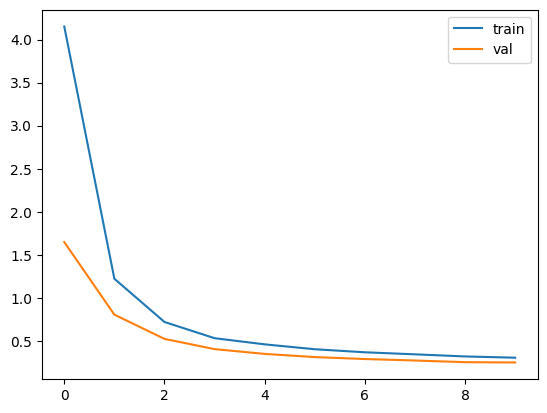

In [69]:
#plot losses
plot_losses(train_loss_lst_lora_rank1, val_loss_lst_lora_rank1)

In [70]:
#Compute test accuracy on MNIST 5...9 for that lora rank
wrong_counts_subset2_lora_rank1 = {i: 0 for i in range(5, 10)}
accuracy_subset2_lora_rank1 = test(test_loader_subset2, "Testing subset2", modified_net, wrong_counts_subset2_lora_rank1)
print(f"Test accuracy on MNIST 5...9 for LoRA rank 1: {accuracy_subset2_lora_rank1}")

Testing subset2: 100%|██████████| 38/38 [00:02<00:00, 12.75it/s]

Accuracy: 0.929
Wrong counts for the digit 5: 91
Wrong counts for the digit 6: 24
Wrong counts for the digit 7: 57
Wrong counts for the digit 8: 82
Wrong counts for the digit 9: 92
Test accuracy on MNIST 5...9 for LoRA rank 1: 0.929


# Try different LoRA rank

__Question 6 (4 points) :__

Fine-tune the pre-trained model using different lora ranks [1,2,4,8,16,32,64], evaluate it on the test set
and store the number of parameters added

Make a plot showing the test accuracy as a function of lora rank. \
Compare it to the test accuracy of the pre-trained model fine-tuned in the usual way on MNIST 5...9

Conclude by looking at the number of parameters added

Discuss what are the pros of LoRA, what possible applications do you envision for it ?

Fine-tuning with LoRA rank 1


Training: 100%|██████████| 161/161 [00:14<00:00, 11.42it/s, loss=3.71]


Epoch [1/10] Train Loss: 3.705724877600344


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.47it/s, loss=1.57]


Epoch [1/10] Validation Loss: 1.5706730113513228


Training: 100%|██████████| 161/161 [00:13<00:00, 11.67it/s, loss=1.24]


Epoch [2/10] Train Loss: 1.2430850004557497


Validation: 100%|██████████| 69/69 [00:05<00:00, 13.62it/s, loss=0.872]


Epoch [2/10] Validation Loss: 0.872330992118172


Training: 100%|██████████| 161/161 [00:13<00:00, 11.76it/s, loss=0.758]


Epoch [3/10] Train Loss: 0.7584588072314766


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.17it/s, loss=0.565]


Epoch [3/10] Validation Loss: 0.564729893985002


Training: 100%|██████████| 161/161 [00:14<00:00, 11.41it/s, loss=0.557]


Epoch [4/10] Train Loss: 0.5565332244642033


Validation: 100%|██████████| 69/69 [00:05<00:00, 13.69it/s, loss=0.436]


Epoch [4/10] Validation Loss: 0.4361451380494712


Training: 100%|██████████| 161/161 [00:13<00:00, 11.64it/s, loss=0.459]


Epoch [5/10] Train Loss: 0.45935133451260396


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.31it/s, loss=0.378]


Epoch [5/10] Validation Loss: 0.37835339640361676


Training: 100%|██████████| 161/161 [00:13<00:00, 11.62it/s, loss=0.403]


Epoch [6/10] Train Loss: 0.4032886816848139


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.82it/s, loss=0.341]


Epoch [6/10] Validation Loss: 0.34053416614947113


Training: 100%|██████████| 161/161 [00:14<00:00, 11.20it/s, loss=0.368]


Epoch [7/10] Train Loss: 0.36797853462074115


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.20it/s, loss=0.319]


Epoch [7/10] Validation Loss: 0.3189485958520917


Training: 100%|██████████| 161/161 [00:13<00:00, 11.68it/s, loss=0.348]


Epoch [8/10] Train Loss: 0.34784684529215654


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.20it/s, loss=0.299]


Epoch [8/10] Validation Loss: 0.2991987384747768


Training: 100%|██████████| 161/161 [00:14<00:00, 11.07it/s, loss=0.328]


Epoch [9/10] Train Loss: 0.32811550721988914


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.74it/s, loss=0.282]


Epoch [9/10] Validation Loss: 0.28150377476560895


Training: 100%|██████████| 161/161 [00:14<00:00, 11.31it/s, loss=0.314]


Epoch [10/10] Train Loss: 0.31425390175040463


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.88it/s, loss=0.268]


Epoch [10/10] Validation Loss: 0.26823509819265723


Testing subset2: 100%|██████████| 38/38 [00:03<00:00, 12.56it/s]


Accuracy: 0.933
Wrong counts for the digit 5: 90
Wrong counts for the digit 6: 26
Wrong counts for the digit 7: 48
Wrong counts for the digit 8: 88
Wrong counts for the digit 9: 76
Test accuracy on MNIST 5...9 for LoRA rank 1: 0.933
Number of parameters introduced by LoRA rank 1: 6789
---
Fine-tuning with LoRA rank 2


Training: 100%|██████████| 161/161 [00:13<00:00, 11.67it/s, loss=3.38]


Epoch [1/10] Train Loss: 3.3838903963195612


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.36it/s, loss=0.999]


Epoch [1/10] Validation Loss: 0.9994122299595155


Training: 100%|██████████| 161/161 [00:13<00:00, 11.58it/s, loss=0.722]


Epoch [2/10] Train Loss: 0.7215409388083108


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.47it/s, loss=0.443]


Epoch [2/10] Validation Loss: 0.44295522764973017


Training: 100%|██████████| 161/161 [00:15<00:00, 10.71it/s, loss=0.449]


Epoch [3/10] Train Loss: 0.44929533215783396


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.78it/s, loss=0.327]


Epoch [3/10] Validation Loss: 0.3272594131421352


Training: 100%|██████████| 161/161 [00:14<00:00, 11.30it/s, loss=0.359]


Epoch [4/10] Train Loss: 0.35865537442775985


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.74it/s, loss=0.268]


Epoch [4/10] Validation Loss: 0.26791336117447284


Training: 100%|██████████| 161/161 [00:14<00:00, 10.86it/s, loss=0.308]


Epoch [5/10] Train Loss: 0.30777897644117014


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.02it/s, loss=0.235]


Epoch [5/10] Validation Loss: 0.23500054308037827


Training: 100%|██████████| 161/161 [00:14<00:00, 11.31it/s, loss=0.283]


Epoch [6/10] Train Loss: 0.28332047909498215


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.43it/s, loss=0.219]


Epoch [6/10] Validation Loss: 0.2186840820139733


Training: 100%|██████████| 161/161 [00:14<00:00, 10.75it/s, loss=0.257]


Epoch [7/10] Train Loss: 0.2572187992356579


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.68it/s, loss=0.201]


Epoch [7/10] Validation Loss: 0.2008186327158541


Training: 100%|██████████| 161/161 [00:14<00:00, 11.24it/s, loss=0.238]


Epoch [8/10] Train Loss: 0.23812541805254006


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.24it/s, loss=0.192]


Epoch [8/10] Validation Loss: 0.19203306043493576


Training: 100%|██████████| 161/161 [00:15<00:00, 10.71it/s, loss=0.229]


Epoch [9/10] Train Loss: 0.22890274786615963


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.53it/s, loss=0.185]


Epoch [9/10] Validation Loss: 0.1850450083181478


Training: 100%|██████████| 161/161 [00:14<00:00, 11.16it/s, loss=0.22]


Epoch [10/10] Train Loss: 0.21988766783883112


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.19it/s, loss=0.172]


Epoch [10/10] Validation Loss: 0.17151864391306174


Testing subset2: 100%|██████████| 38/38 [00:02<00:00, 12.97it/s]


Accuracy: 0.945
Wrong counts for the digit 5: 54
Wrong counts for the digit 6: 25
Wrong counts for the digit 7: 44
Wrong counts for the digit 8: 80
Wrong counts for the digit 9: 66
Test accuracy on MNIST 5...9 for LoRA rank 2: 0.945
Number of parameters introduced by LoRA rank 2: 13578
---
Fine-tuning with LoRA rank 4


Training: 100%|██████████| 161/161 [00:13<00:00, 11.66it/s, loss=2.23]


Epoch [1/10] Train Loss: 2.2328316511944952


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.28it/s, loss=0.45]


Epoch [1/10] Validation Loss: 0.4503904304642608


Training: 100%|██████████| 161/161 [00:14<00:00, 11.44it/s, loss=0.42]


Epoch [2/10] Train Loss: 0.419788471475151


Validation: 100%|██████████| 69/69 [00:05<00:00, 13.65it/s, loss=0.293]


Epoch [2/10] Validation Loss: 0.2927076989325924


Training: 100%|██████████| 161/161 [00:14<00:00, 11.40it/s, loss=0.302]


Epoch [3/10] Train Loss: 0.30190729150860945


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.97it/s, loss=0.225]


Epoch [3/10] Validation Loss: 0.22493922645631043


Training: 100%|██████████| 161/161 [00:14<00:00, 11.32it/s, loss=0.254]


Epoch [4/10] Train Loss: 0.2540815384676738


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.04it/s, loss=0.187]


Epoch [4/10] Validation Loss: 0.18738997025766235


Training: 100%|██████████| 161/161 [00:14<00:00, 11.09it/s, loss=0.222]


Epoch [5/10] Train Loss: 0.22166287866623505


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.87it/s, loss=0.168]


Epoch [5/10] Validation Loss: 0.16780881302944128


Training: 100%|██████████| 161/161 [00:14<00:00, 11.42it/s, loss=0.198]


Epoch [6/10] Train Loss: 0.19835734774607308


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.78it/s, loss=0.147]


Epoch [6/10] Validation Loss: 0.14742845977130142


Training: 100%|██████████| 161/161 [00:14<00:00, 11.01it/s, loss=0.183]


Epoch [7/10] Train Loss: 0.18323538683771345


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.20it/s, loss=0.139]


Epoch [7/10] Validation Loss: 0.13873719542786694


Training: 100%|██████████| 161/161 [00:14<00:00, 11.50it/s, loss=0.178]


Epoch [8/10] Train Loss: 0.17764972418731784


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.72it/s, loss=0.132]


Epoch [8/10] Validation Loss: 0.1320631042446779


Training: 100%|██████████| 161/161 [00:14<00:00, 10.98it/s, loss=0.16]


Epoch [9/10] Train Loss: 0.15998973299442612


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.13it/s, loss=0.125]


Epoch [9/10] Validation Loss: 0.12496359754299773


Training: 100%|██████████| 161/161 [00:14<00:00, 11.18it/s, loss=0.159]


Epoch [10/10] Train Loss: 0.15863227483278475


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.68it/s, loss=0.127]


Epoch [10/10] Validation Loss: 0.12703658651182617


Testing subset2: 100%|██████████| 38/38 [00:03<00:00, 12.15it/s]


Accuracy: 0.958
Wrong counts for the digit 5: 40
Wrong counts for the digit 6: 17
Wrong counts for the digit 7: 28
Wrong counts for the digit 8: 51
Wrong counts for the digit 9: 67
Test accuracy on MNIST 5...9 for LoRA rank 4: 0.958
Number of parameters introduced by LoRA rank 4: 27156
---
Fine-tuning with LoRA rank 8


Training: 100%|██████████| 161/161 [00:14<00:00, 11.34it/s, loss=1.36]


Epoch [1/10] Train Loss: 1.364543990133712


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.94it/s, loss=0.303]


Epoch [1/10] Validation Loss: 0.3030712945737701


Training: 100%|██████████| 161/161 [00:14<00:00, 11.16it/s, loss=0.274]


Epoch [2/10] Train Loss: 0.27367924255613957


Validation: 100%|██████████| 69/69 [00:05<00:00, 13.32it/s, loss=0.182]


Epoch [2/10] Validation Loss: 0.18193301893230798


Training: 100%|██████████| 161/161 [00:14<00:00, 11.38it/s, loss=0.204]


Epoch [3/10] Train Loss: 0.20414842438438666


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.10it/s, loss=0.136]


Epoch [3/10] Validation Loss: 0.1364924608581308


Training: 100%|██████████| 161/161 [00:14<00:00, 11.35it/s, loss=0.165]


Epoch [4/10] Train Loss: 0.16540743794685564


Validation: 100%|██████████| 69/69 [00:04<00:00, 13.97it/s, loss=0.117]


Epoch [4/10] Validation Loss: 0.11716000811345335


Training: 100%|██████████| 161/161 [00:14<00:00, 10.96it/s, loss=0.147]


Epoch [5/10] Train Loss: 0.14662198884331662


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.60it/s, loss=0.107]


Epoch [5/10] Validation Loss: 0.10666335854625357


Training: 100%|██████████| 161/161 [00:14<00:00, 11.31it/s, loss=0.133]


Epoch [6/10] Train Loss: 0.13293918323998125


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.34it/s, loss=0.102]


Epoch [6/10] Validation Loss: 0.10224625662617061


Training: 100%|██████████| 161/161 [00:14<00:00, 11.15it/s, loss=0.12]


Epoch [7/10] Train Loss: 0.11951031297537851


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.28it/s, loss=0.0879]


Epoch [7/10] Validation Loss: 0.08790507880241974


Training: 100%|██████████| 161/161 [00:14<00:00, 11.32it/s, loss=0.109]


Epoch [8/10] Train Loss: 0.10882167330717449


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.19it/s, loss=0.0882]


Epoch [8/10] Validation Loss: 0.08817259354543859


Training: 100%|██████████| 161/161 [00:14<00:00, 10.97it/s, loss=0.104]


Epoch [9/10] Train Loss: 0.10379376596776965


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.07it/s, loss=0.0823]


Epoch [9/10] Validation Loss: 0.08226397679443809


Training: 100%|██████████| 161/161 [00:14<00:00, 11.15it/s, loss=0.0955]


Epoch [10/10] Train Loss: 0.09551649960625616


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.89it/s, loss=0.0793]


Epoch [10/10] Validation Loss: 0.07928538308951302


Testing subset2: 100%|██████████| 38/38 [00:03<00:00, 12.62it/s]


Accuracy: 0.973
Wrong counts for the digit 5: 20
Wrong counts for the digit 6: 11
Wrong counts for the digit 7: 23
Wrong counts for the digit 8: 42
Wrong counts for the digit 9: 33
Test accuracy on MNIST 5...9 for LoRA rank 8: 0.973
Number of parameters introduced by LoRA rank 8: 54312
---
Fine-tuning with LoRA rank 16


Training: 100%|██████████| 161/161 [00:14<00:00, 11.42it/s, loss=0.925]


Epoch [1/10] Train Loss: 0.925086240313068


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.13it/s, loss=0.18]


Epoch [1/10] Validation Loss: 0.18003174619398254


Training: 100%|██████████| 161/161 [00:14<00:00, 11.24it/s, loss=0.182]


Epoch [2/10] Train Loss: 0.18235392819928087


Validation: 100%|██████████| 69/69 [00:05<00:00, 13.41it/s, loss=0.119]


Epoch [2/10] Validation Loss: 0.1187865523810404


Training: 100%|██████████| 161/161 [00:14<00:00, 11.29it/s, loss=0.13]


Epoch [3/10] Train Loss: 0.12998146629712967


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.26it/s, loss=0.0924]


Epoch [3/10] Validation Loss: 0.09244487175474995


Training: 100%|██████████| 161/161 [00:14<00:00, 11.27it/s, loss=0.109]


Epoch [4/10] Train Loss: 0.10917492133351217


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.08it/s, loss=0.0874]


Epoch [4/10] Validation Loss: 0.08735751028618087


Training: 100%|██████████| 161/161 [00:14<00:00, 11.16it/s, loss=0.0968]


Epoch [5/10] Train Loss: 0.09681078839052168


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.24it/s, loss=0.0785]


Epoch [5/10] Validation Loss: 0.07849839640160401


Training: 100%|██████████| 161/161 [00:14<00:00, 11.48it/s, loss=0.0796]


Epoch [6/10] Train Loss: 0.0796057262012492


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.91it/s, loss=0.0708]


Epoch [6/10] Validation Loss: 0.07081103820245767


Training: 100%|██████████| 161/161 [00:14<00:00, 11.06it/s, loss=0.0759]


Epoch [7/10] Train Loss: 0.07590250709666783


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.31it/s, loss=0.0695]


Epoch [7/10] Validation Loss: 0.06946578663706347


Training: 100%|██████████| 161/161 [00:14<00:00, 11.32it/s, loss=0.0677]


Epoch [8/10] Train Loss: 0.06769101048952766


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.63it/s, loss=0.0731]


Epoch [8/10] Validation Loss: 0.07307140650632589


Training: 100%|██████████| 161/161 [00:15<00:00, 10.63it/s, loss=0.06]


Epoch [9/10] Train Loss: 0.06000639681027543


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.89it/s, loss=0.0669]


Epoch [9/10] Validation Loss: 0.06686265673488379


Training: 100%|██████████| 161/161 [00:14<00:00, 11.25it/s, loss=0.0564]


Epoch [10/10] Train Loss: 0.056443258674572346


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.86it/s, loss=0.0745]


Epoch [10/10] Validation Loss: 0.07451433834174405


Testing subset2: 100%|██████████| 38/38 [00:02<00:00, 12.71it/s]


Accuracy: 0.978
Wrong counts for the digit 5: 18
Wrong counts for the digit 6: 9
Wrong counts for the digit 7: 13
Wrong counts for the digit 8: 23
Wrong counts for the digit 9: 42
Test accuracy on MNIST 5...9 for LoRA rank 16: 0.978
Number of parameters introduced by LoRA rank 16: 108624
---
Fine-tuning with LoRA rank 32


Training: 100%|██████████| 161/161 [00:14<00:00, 11.11it/s, loss=0.594]


Epoch [1/10] Train Loss: 0.5941888022681941


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.26it/s, loss=0.127]


Epoch [1/10] Validation Loss: 0.12665997828910316


Training: 100%|██████████| 161/161 [00:14<00:00, 11.11it/s, loss=0.125]


Epoch [2/10] Train Loss: 0.12450964677130213


Validation: 100%|██████████| 69/69 [00:05<00:00, 13.48it/s, loss=0.0914]


Epoch [2/10] Validation Loss: 0.09143364893785422


Training: 100%|██████████| 161/161 [00:14<00:00, 11.12it/s, loss=0.0925]


Epoch [3/10] Train Loss: 0.09252002146904884


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.93it/s, loss=0.0782]


Epoch [3/10] Validation Loss: 0.0782060374006413


Training: 100%|██████████| 161/161 [00:14<00:00, 11.08it/s, loss=0.0717]


Epoch [4/10] Train Loss: 0.07167572089071785


Validation: 100%|██████████| 69/69 [00:05<00:00, 13.42it/s, loss=0.067]


Epoch [4/10] Validation Loss: 0.06695523316823486


Training: 100%|██████████| 161/161 [00:14<00:00, 11.06it/s, loss=0.057]


Epoch [5/10] Train Loss: 0.05704153422844706


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.17it/s, loss=0.0668]


Epoch [5/10] Validation Loss: 0.06676199291900232


Training: 100%|██████████| 161/161 [00:14<00:00, 11.13it/s, loss=0.0496]


Epoch [6/10] Train Loss: 0.049609892981369856


Validation: 100%|██████████| 69/69 [00:05<00:00, 13.36it/s, loss=0.0657]


Epoch [6/10] Validation Loss: 0.06568244346619947


Training: 100%|██████████| 161/161 [00:14<00:00, 10.99it/s, loss=0.0457]


Epoch [7/10] Train Loss: 0.0456510387326342


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.07it/s, loss=0.0715]


Epoch [7/10] Validation Loss: 0.07150011637545042


Training: 100%|██████████| 161/161 [00:14<00:00, 11.13it/s, loss=0.0403]


Epoch [8/10] Train Loss: 0.040334259514170495


Validation: 100%|██████████| 69/69 [00:05<00:00, 13.45it/s, loss=0.0568]


Epoch [8/10] Validation Loss: 0.056778050979356405


Training: 100%|██████████| 161/161 [00:14<00:00, 11.08it/s, loss=0.035]


Epoch [9/10] Train Loss: 0.03496101797957506


Validation: 100%|██████████| 69/69 [00:04<00:00, 16.07it/s, loss=0.0589]


Epoch [9/10] Validation Loss: 0.05886235270325257


Training: 100%|██████████| 161/161 [00:14<00:00, 11.15it/s, loss=0.0342]


Epoch [10/10] Train Loss: 0.03424039631734909


Validation: 100%|██████████| 69/69 [00:05<00:00, 13.50it/s, loss=0.0642]


Epoch [10/10] Validation Loss: 0.064187066393324


Testing subset2: 100%|██████████| 38/38 [00:02<00:00, 17.36it/s]


Accuracy: 0.982
Wrong counts for the digit 5: 17
Wrong counts for the digit 6: 15
Wrong counts for the digit 7: 18
Wrong counts for the digit 8: 22
Wrong counts for the digit 9: 17
Test accuracy on MNIST 5...9 for LoRA rank 32: 0.982
Number of parameters introduced by LoRA rank 32: 217248
---
Fine-tuning with LoRA rank 64


Training: 100%|██████████| 161/161 [00:15<00:00, 10.71it/s, loss=0.423]


Epoch [1/10] Train Loss: 0.4234344021457693


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.70it/s, loss=0.0872]


Epoch [1/10] Validation Loss: 0.08719788394544435


Training: 100%|██████████| 161/161 [00:15<00:00, 10.15it/s, loss=0.0919]


Epoch [2/10] Train Loss: 0.09185235292552421


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.08it/s, loss=0.0671]


Epoch [2/10] Validation Loss: 0.06706960755062924


Training: 100%|██████████| 161/161 [00:15<00:00, 10.62it/s, loss=0.0627]


Epoch [3/10] Train Loss: 0.06271740546600418


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.49it/s, loss=0.0695]


Epoch [3/10] Validation Loss: 0.06948999940431204


Training: 100%|██████████| 161/161 [00:15<00:00, 10.33it/s, loss=0.0478]


Epoch [4/10] Train Loss: 0.047807308359314564


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.77it/s, loss=0.0728]


Epoch [4/10] Validation Loss: 0.07281506748910507


Training: 100%|██████████| 161/161 [00:15<00:00, 10.70it/s, loss=0.0417]


Epoch [5/10] Train Loss: 0.041727379083008685


Validation: 100%|██████████| 69/69 [00:05<00:00, 13.25it/s, loss=0.0701]


Epoch [5/10] Validation Loss: 0.07014894845180106


Training: 100%|██████████| 161/161 [00:15<00:00, 10.65it/s, loss=0.0319]


Epoch [6/10] Train Loss: 0.03191495028625225


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.94it/s, loss=0.0632]


Epoch [6/10] Validation Loss: 0.0631806257609413


Training: 100%|██████████| 161/161 [00:15<00:00, 10.57it/s, loss=0.0277]


Epoch [7/10] Train Loss: 0.027746605639120344


Validation: 100%|██████████| 69/69 [00:05<00:00, 13.31it/s, loss=0.0837]


Epoch [7/10] Validation Loss: 0.08365948117621567


Training: 100%|██████████| 161/161 [00:15<00:00, 10.64it/s, loss=0.0314]


Epoch [8/10] Train Loss: 0.03140555556447054


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.62it/s, loss=0.0687]


Epoch [8/10] Validation Loss: 0.06872264688844672


Training: 100%|██████████| 161/161 [00:15<00:00, 10.33it/s, loss=0.0237]


Epoch [9/10] Train Loss: 0.02372891812202787


Validation: 100%|██████████| 69/69 [00:04<00:00, 14.34it/s, loss=0.0695]


Epoch [9/10] Validation Loss: 0.0695034438825172


Training: 100%|██████████| 161/161 [00:15<00:00, 10.59it/s, loss=0.023]


Epoch [10/10] Train Loss: 0.02301689074483197


Validation: 100%|██████████| 69/69 [00:04<00:00, 15.73it/s, loss=0.064]


Epoch [10/10] Validation Loss: 0.06399053060179712


Testing subset2: 100%|██████████| 38/38 [00:03<00:00, 11.91it/s]


Accuracy: 0.987
Wrong counts for the digit 5: 19
Wrong counts for the digit 6: 10
Wrong counts for the digit 7: 11
Wrong counts for the digit 8: 5
Wrong counts for the digit 9: 18
Test accuracy on MNIST 5...9 for LoRA rank 64: 0.987
Number of parameters introduced by LoRA rank 64: 434496
---


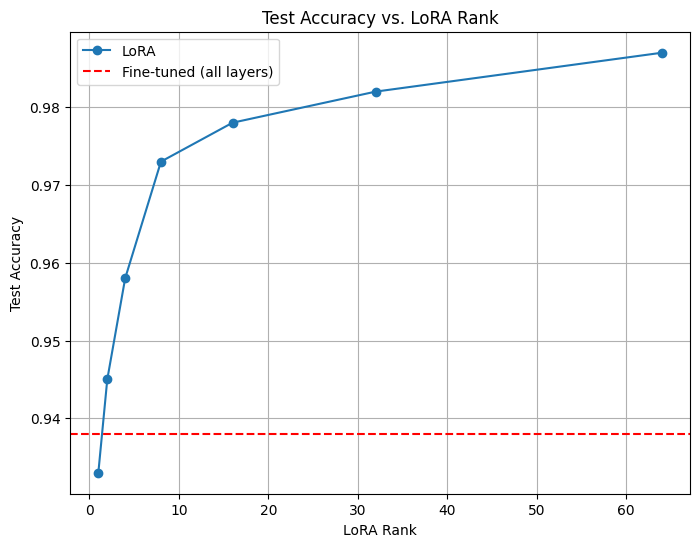

LoRA Rank 1: 6789 parameters added
LoRA Rank 2: 13578 parameters added
LoRA Rank 4: 27156 parameters added
LoRA Rank 8: 54312 parameters added
LoRA Rank 16: 108624 parameters added
LoRA Rank 32: 217248 parameters added
LoRA Rank 64: 434496 parameters added


In [72]:
lora_ranks = [1, 2, 4, 8, 16, 32, 64]
lora_test_accuracies = []
lora_params_counts = []

for rank in lora_ranks:
    print(f"Fine-tuning with LoRA rank {rank}")

    # Create a new instance of the modified network with the current LoRA rank
    modified_net = ModifiedClassifier(rank).to(device)

    # Fine-tune the model with the current LoRA rank
    train_loss_lst_lora, val_loss_lst_lora = train(train_loader_subset2, val_loader_subset2, "subset2", modified_net, epochs=10)

    # Compute test accuracy on MNIST 5...9 for the current LoRA rank
    wrong_counts_subset2_lora = {i: 0 for i in range(5, 10)}
    accuracy_subset2_lora = test(test_loader_subset2, "Testing subset2", modified_net, wrong_counts_subset2_lora)
    lora_test_accuracies.append(accuracy_subset2_lora)

    # Count the number of parameters introduced by LoRA layers
    lora_params_count = count_lora_parameters(modified_net)
    lora_params_counts.append(lora_params_count)

    print(f"Test accuracy on MNIST 5...9 for LoRA rank {rank}: {accuracy_subset2_lora}")
    print(f"Number of parameters introduced by LoRA rank {rank}: {lora_params_count}")
    print("---")

# Plot the test accuracy as a function of LoRA rank
plt.figure(figsize=(8, 6))
plt.plot(lora_ranks, lora_test_accuracies, marker='o', label='LoRA')
plt.axhline(accuracy_finetuned_all, color='r', linestyle='--', label='Fine-tuned (all layers)')
plt.xlabel('LoRA Rank')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. LoRA Rank')
plt.legend()
plt.grid(True)
plt.show()

# Print the number of parameters added by each LoRA rank
for rank, params_count in zip(lora_ranks, lora_params_counts):
    print(f"LoRA Rank {rank}: {params_count} parameters added")

Result analysis:
Better rank, more parameters and so better final accuracy.
Better accuracy than if we finetuned all layers.

Here are a few key pros of LoRA and potential applications we envision:

**Pros:**
- Adds only a small number of parameters, reducing memory usage
- Enables faster fine-tuning by updating only LoRA parameters  
- Preserves valuable pre-trained knowledge in frozen base model
- Allows flexibility in balancing added parameters vs adaptation capacity

**Applications:**
- Adapting models to specialized domains (e.g. medical images)
- Personalizing models for individual users/preferences
- Learning from limited labeled data by leveraging pre-trained models
- Continual learning to incrementally adapt to new tasks
- Compressing large models while retaining performance
